In [1]:
from mpc import *
from IPython.display import display, Markdown, Latex

### Simulation parameters
Defines the total simulation time and sampling time.

In [2]:
# Total simulation time: 24h (1440m)
total_time = 1440  

# Sampling time: 1m
t_step = 1

# Number of control step total_time/t_step: 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# Initial conditions
x_0 = np.array([30, 50, 400, 125, 0, 0])

# References
LacI_ref = 750
TetR_ref = 300


### Control loop
It defines the parameters of the controller, instantiates the object of the model class to be controlled and the object of the controller class and starts the control loop.

In [3]:
setup_mpc = {
    'n_robust': 1,
    'n_horizon': 7,
    't_step': t_step,
    'store_full_solution': True,
}

toggle = ToggleSwitchUncertainModel(False, LacI_ref, TetR_ref, t_step, total_time, avg_period)
mpc_controller = ControllerMPC(toggle, t_step, setup_mpc, False)
mpc_controller.control_loop(x_0, steps, 'uncertain', 1)

### Performance metrics and results plot
It calculates ISE and ITAE values and plots closed-loop simulations.

#### Performance metrics


<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | 25.73     |
| ITAE       | 7.51e+04    |


#### Results plot

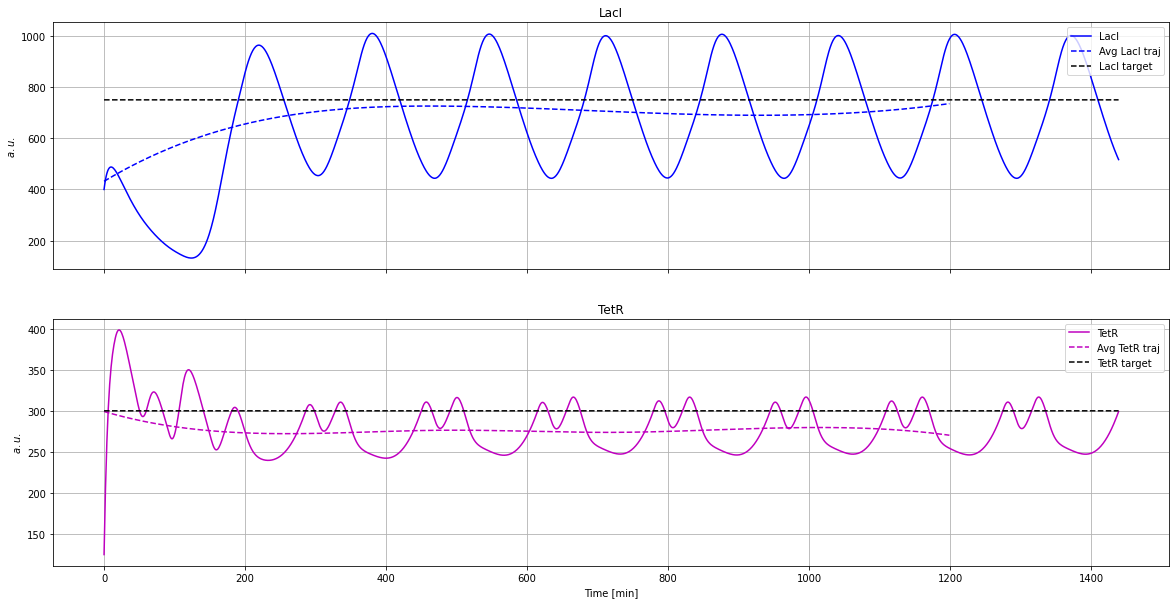

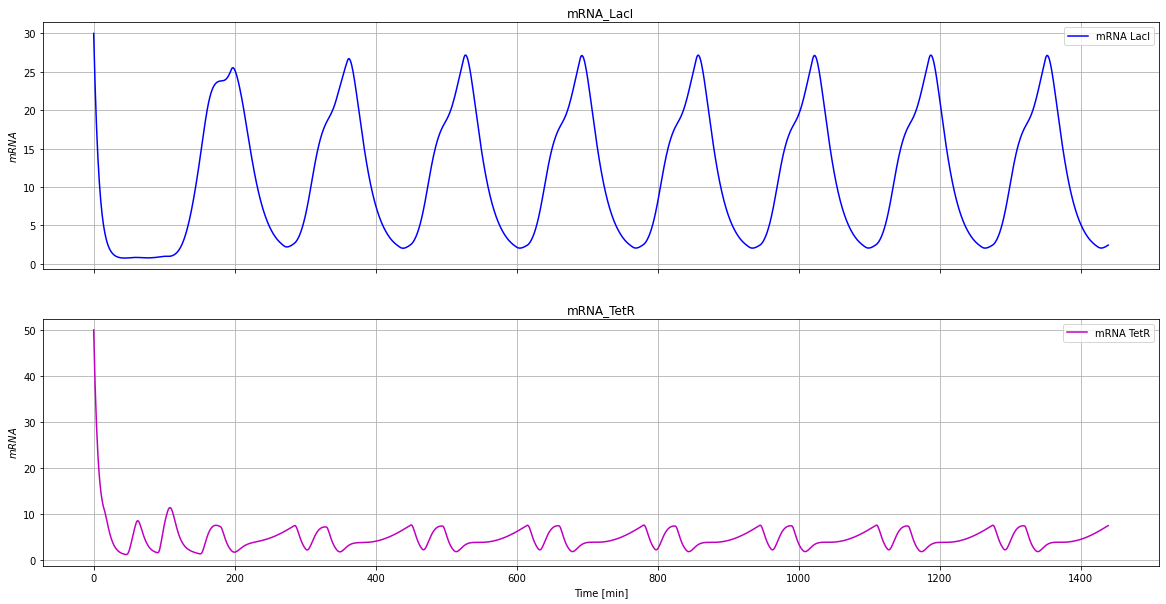

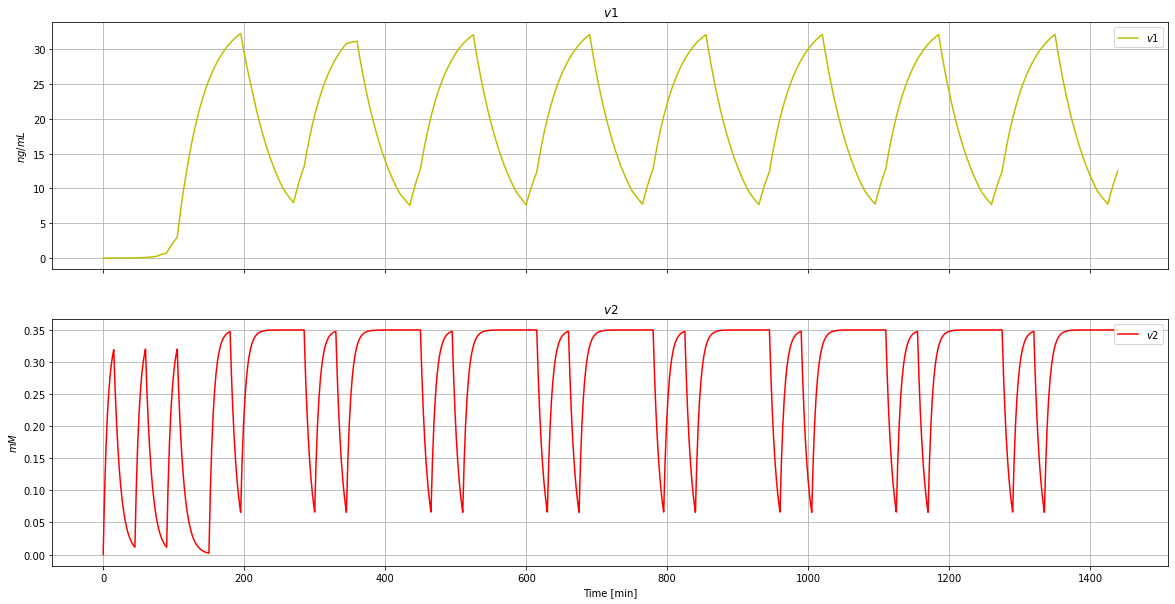

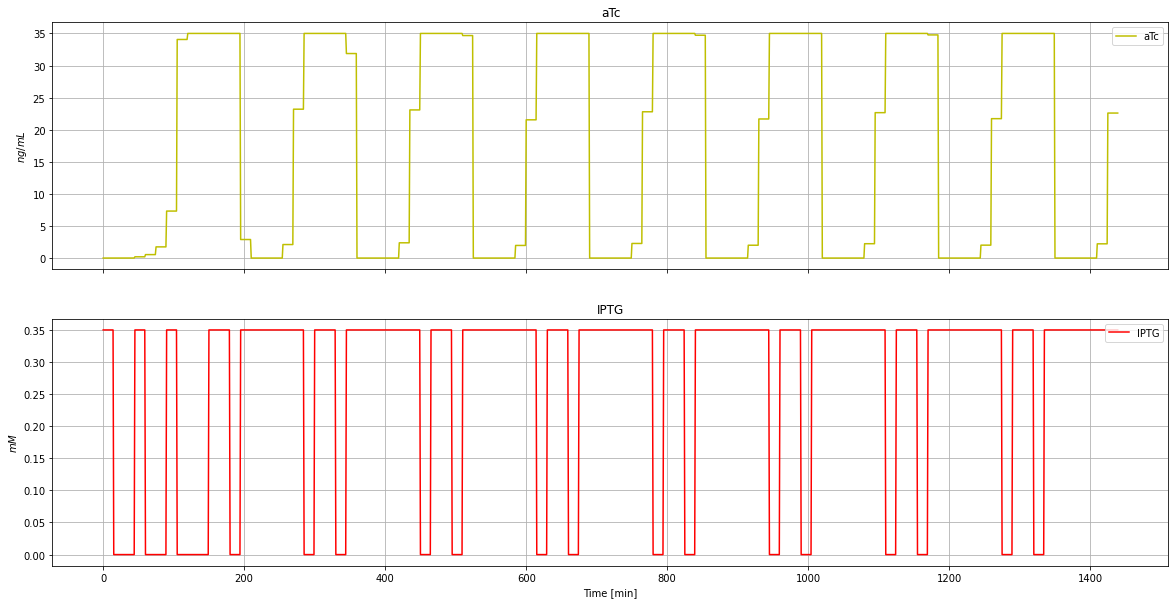

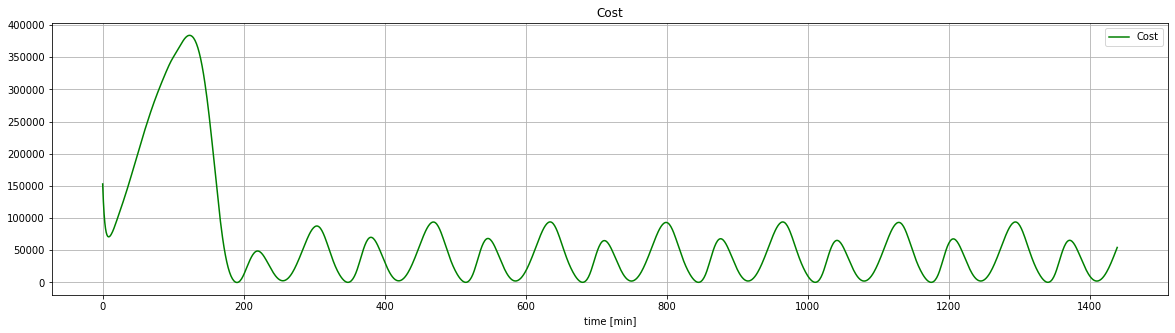

In [4]:
display(Markdown('#### Performance metrics'))
metrics = """
<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | {ISE}     |
| ITAE       | {ITAE}    |
""".format(ISE = "{:.2f}".format(toggle.trajectories['ISE']), ITAE = format(toggle.trajectories['ITAE'], '.2e'))

display(Markdown(metrics))

display(Markdown('#### Results plot'))
figures, lines = toggle.plot_results()


### Predicted trajectories
Plots the predicted trajectories

In [5]:
mpc_graphics = do_mpc.graphics.Graphics(mpc_controller.controller.data)

def animate(i):
    mpc_graphics.plot_predictions(i)
    mpc_graphics.reset_axes()

In [14]:
%%capture

fig_x = 20
fig_y = 10

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14

figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))

mpc_graphics.add_line(var_type='_x', var_name='mRNA_LacI', axis=axes[0])
for line in mpc_graphics.pred_lines['_x', 'mRNA_LacI']: line.set_color('b')
mpc_graphics.add_line(var_type='_x', var_name='mRNA_TetR', axis=axes[1])
for line in mpc_graphics.pred_lines['_x', 'mRNA_TetR']: line.set_color('m')
axes[0].set_ylabel(r'$mRNA$')
axes[0].set_title('mRNA LacI')
axes[1].set_ylabel(r'$mRNA$')
axes[1].set_title('mRNA TetR')
axes[1].set_xlabel('Time [min]')

mpc_graphics.clear()
anim = animation.FuncAnimation(figure, animate, frames=steps)
anim.save('./simulations/uncertain/mRNAS.mp4', fps=24)

figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))
mpc_graphics.add_line(var_type='_x', var_name='LacI', axis=axes[0])
for line in mpc_graphics.pred_lines['_x', 'LacI']: line.set_color('b')
mpc_graphics.add_line(var_type='_x', var_name='TetR', axis=axes[1])
for line in mpc_graphics.pred_lines['_x', 'TetR']: line.set_color('m')
axes[0].set_ylabel(r'$a.u.$')
axes[0].set_title('LacI')
axes[1].set_ylabel(r'$a.u.$')
axes[1].set_title('TetR')
axes[1].set_xlabel('Time [min]')

mpc_graphics.clear()
anim = animation.FuncAnimation(figure, animate, frames=steps)
anim.save('./simulations/uncertain/proteins.mp4', fps=24)

figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))
mpc_graphics.add_line(var_type='_x', var_name='v1', axis=axes[0])
for line in mpc_graphics.pred_lines['_x', 'v1']: line.set_color('y')
mpc_graphics.add_line(var_type='_x', var_name='v2', axis=axes[1])
for line in mpc_graphics.pred_lines['_x', 'v2']: line.set_color('r')
axes[0].set_ylabel(r'$ng/mL$')
axes[0].set_title('v1')
axes[1].set_ylabel(r'$mM$')
axes[1].set_title('v2')
axes[1].set_xlabel('Time [min]')

mpc_graphics.clear()
anim = animation.FuncAnimation(figure, animate, frames=steps)
anim.save('./simulations/uncertain/internal_inducers.mp4', fps=24)

figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))
mpc_graphics.add_line(var_type='_u', var_name='aTc', axis=axes[0])
for line in mpc_graphics.pred_lines['_u', 'aTc']: line.set_color('y')
mpc_graphics.add_line(var_type='_u', var_name='IPTG', axis=axes[1])
for line in mpc_graphics.pred_lines['_u', 'IPTG']: line.set_color('r')
axes[0].set_ylabel(r'$ng/mL$')
axes[0].set_title('aTc')
axes[1].set_ylabel(r'$mM$')
axes[1].set_title('IPTg')
axes[1].set_xlabel('Time [min]')

mpc_graphics.clear()
anim = animation.FuncAnimation(figure, animate, frames=steps)
anim.save('./simulations/uncertain/external_inducers.mp4', fps=24)